# Assignment 8: Exploration of our neural network in MNIST
In this assignment, I would like you to add some features to our neural network , and then use this to optimize its performance.

Tasks:
1.  During training, as one cycles over the epochs, it is helpful to keep track of the test set performance.   At the end of each epoch,  calculate the training and test set accuracy.   Plot these to see how the performance changes vs epoch.   You could try to come up with a way to automatically stop the training.
2.  Add the confusion matrix calculation to the summary performance information that is calculated when training is done.
3.  Optimize this network for the number of hidden nodes.   Do this the correct way!

Extra:
1.  Did you notice that there is structure in the cost function plot?   What is the source of this structure?   Can you remove it?
2.  This is more involved: add another hidden layer to the network.   You will have to modify the forward pass as well as the backpropagation methods.


##Basic mathematical functions

In [0]:
import numpy as np

def sigmoid(z):
  sm = 1.0 / (1.0 + np.exp(z))
  return sm

def sigmoid_deriv(z):
  sm = sigmoid(z)*(1-sigmoid(z))
  return sm

def tanh(z):
  return np.tanh(z)


def tanh_deriv(z):
  return 1 - np.square(np.tanh(z))

#The output v has the same shape as the input v
def softmaxNew(v):
  # v is of shape (m, k)
  logC = -np.max(v)
  #For every element in the v matrix, it is shifted, 
  # to keep the element from getting too big that it freaks out the exponential
  #np.sum(np.exp(v + loC), axis=1)[:, np.newaxis] is of shape m
  #np.exp(v + logC)/np.sum(np.exp(v + logC), axis = 1)[:,np.newaxis] 
  return np.exp(v + logC)/np.sum(np.exp(v + logC), axis = 1)[:,np.newaxis] # Shape is (m,k)

def autovivify(levels=1, final=dict):
    return (defaultdict(final) if levels < 2 else
            defaultdict(lambda: autovivify(levels-1, final)))

##Get the google drive ready.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
#!{sys.executable} -m pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Import the MNIST data and onehot encode the labels.
Make train and test sets.

In [3]:
#Import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Form our test and train data
from sklearn.model_selection import train_test_split

#short = ""
short = "short_"
dfCombined = pd.DataFrame()
#
# Read in digits
for digit in range(10):
    fname = 'https://raw.githubusercontent.com/big-data-analytics-physics/data/master/ch3/digit_' + short + str(digit) + '.csv'
    df = pd.read_csv(fname,header=None)
    df['digit'] = digit
    dfCombined = pd.concat([dfCombined, df])

train_digits,test_digits = train_test_split(dfCombined, test_size=0.3, random_state=42)
yTrain_digit = train_digits['digit'].values
XTrain = train_digits.as_matrix(columns=train_digits.columns[:784])

yTest_digit = test_digits['digit'].values
XTest = test_digits.as_matrix(columns=test_digits.columns[:784])

#onehot encode the train labels
yTrain_oneHot = np.zeros((len(yTrain_digit), 10))
for i in range(len(yTrain_digit)):
    yTrain_oneHot[i][yTrain_digit[i]] = 1

#onehot encode the test labels    
yTest_oneHot = np.zeros((len(yTest_digit), 10))
for i in range(len(yTest_digit)):
    yTest_oneHot[i][yTest_digit[i]] = 1
    

#Normalize the grayscale figure
XTrain = XTrain / 255.0
XTest = XTest / 255.0
#
print("XTrain",XTrain.shape)
print("XTest",XTest.shape)

print("yTrain_oneHot", yTrain_oneHot.shape, yTrain_oneHot[20])
print("yTest_oneHot", yTest_oneHot.shape, yTest_oneHot[20])

XTrain (7000, 784)
XTest (3000, 784)
yTrain_oneHot (7000, 10) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
yTest_oneHot (3000, 10) [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


#Define the Neural Network class to facilitate future reuse.


##Define the class
A neural network of any depth can be defined using a list of the numbers of hidden layer nodes. 

In [0]:
import time

#Generate the same initial guesses so that we can reliably compare the results between models.

#To allow the reuse of fitted models, we should import weight and layers hidden layers
class neuralNetwork:
    #We can skip passing the sample data and w for now.
    def __init__(self, X=None, w=None, Lambda=0.0):
        self.X = X
        self.w = w
        self.Lambda = Lambda
        
        self.a = [] #a[i] is the matrix immediately before being linearly mapped to a neural layer[i+1]
        self.z = [] #z[i] is the neural layer
        self.probs = None
        
        if self.X == None:
            print("No sample data passed, please use load() or initialize() to build your network")
            
        if self.w == None:
            print("No weights layers passed, please use load() or initialize() to build your network")
    
    def clearMemory(self):
        self.X = None
        
        self.w = []
        self.z = []
        self.a = []
        
        self.Lambda = 0.0
        
        self.probs = None
        
    #If no sample data and w was passed, we can initialize the neural network now.
    #Load just needs to care about the original sample and the weights..
    def load(self, X, filename, link, num_of_weights_layers):
        self.clearMemory()
        
        self.X = X
        self.w = []
        
#        if loadFromGoogleDrive == False:
#            file = open(filename, 'w')
#            #Write the Lambda then the weights
#            self.Lambda = float(file.readlines())
#            print("The Lambda is:", self.Lambda)
#            
#            for shape in shapes:
#                w = np.zeros(shape)
#                for i in range(shape[0]):
#                    w[i] = np.fromstring(file.readlines(), dtype=float, sep=',').copy()
#                print("Loading weights layer: ", w.shape)
#                self.w.append(w)
#                
#            file.close()
#                
#        else:
        id = link.split('=')[1]
        print("The file to read has name", filename)
        print("The file to read has id: ", id)
        downloaded = drive.CreateFile({'id': id})
        downloaded.GetContentFile(filename)
        file = open(filename, 'r')
        info = file.readlines()
        
        
        self.Lambda = float(info[0])
        print("The Lambda is:", self.Lambda)
        print(info)
        
        shapes = []
        for i in range(1, num_of_weights_layers + 1):
            array = np.fromstring(info[i], dtype=float, sep=',')
            shape = (int(array[0]), int(array[1]))
            shapes.append(shape)
            
        print("The shape of the weights layers are: ", shapes)
        #We have generated a list of shapes which allows us to read in the data in the correct form.
        
        load_start = num_of_weights_layers + 1
        for shape in shapes:
            w = np.zeros(shape)
            for i in range(load_start, load_start + shape[0]):
                w[i-load_start] = np.fromstring(info[i], dtype=float, sep=',').copy()
            print("Loading weights layer: ", w.shape)
            self.w.append(w)
            load_start += shape[0] #Move the load position to get ready for the next layers reading.
        #The spacing line created in the writing process is ignore by the file.readlines()
        
        self.z = [i for i in range(0, len(self.w)+1)]
        self.z[0] = self.X
        
        self.forward_pass(self.X)
        
        
    def export(self):
        time_mark  = str(time.gmtime().tm_year) + '_' + str(time.gmtime().tm_mon) + '_' + str(time.gmtime().tm_mday) + '_' + str(time.gmtime().tm_hour) + '_' + str(time.gmtime().tm_min)
        model_shapes = ""
        for w in self.w:
            model_shapes += '_' + str(w.shape[0]) + 'x' + str(w.shape[1])
            
        filename = time_mark + model_shapes
        
        print("The filename will be: ", filename)
        
        with open("/content/gdrive/My Drive/NeuralNetwork/" + filename + ".text", 'w') as f:
            f.write(str(self.Lambda) + "\n")
            print("Lambda exported: ", self.Lambda)
            
            for i in self.w:
                f.write(str(i.shape[0]) + ',' + str(i.shape[1]) + '\n')   
            
            for i in range(len(self.w)):
                for j in range(len(self.w[i])):
                    self.w[i][j].tofile(f, sep=',')
                    f.write('\n')
                f.write('\n') #Leave a spacing line between different w layers
            
    
    def initialize(self, X, hidden_nodes, Lambda = 0.0):
        self.clearMemory()
        
        self.X = X
        #Start generating weights layers
        print("All memory of current progress has been cleared\nRandomly generating new network layers using hidden_nodes")
        print("The numbers of hidden nodes are: ", hidden_nodes)
        np.random.seed(42)
        self.w.append(np.random.uniform(-1, 1, size=(hidden_nodes[0], self.X.shape[1] + 1)))
        print("The #0 weights layer is RNGed, shape: ", type(self.w), self.w[0].shape)

        for i in range(1, len(hidden_nodes)):
            np.random.seed(42)
            self.w.append(np.random.uniform(-1, 1, size=(hidden_nodes[i], self.w[i-1].shape[0] + 1)))
            print("The #", i, " weights layer is RNGed, shape: ", self.w[i].shape)
        
        
        #Now we have X and w , we can invoke forward_pass() to flesh out the network
        self.a, self.z, self.probs = self.forward_pass(self.X)
        
        print("The original sample:\n", type(self.X), self.X.shape)
        for i in range(len(self.z)):
            print("The generated neural layers: z[", i, "] is ", type(self.z[i]), self.z[i].shape)
        for i in range(len(self.a)):
            print("The a list: a[", i, "] is", type(self.a[i]))
        print("The output probabilities are:\n", type(self.probs), self.probs.shape)
                
    #We don't change the weights matrices, but we generate new a and z matrices all the time.
    #Take in the X, w and flesh out all the other data.
    def forward_pass(self, X):
        a = None
        a = [i for i in range(len(self.w))]
        #self.we should have self.w and X at this point, noself.w let's calculate a, z, probs.
        z = [i for i in range(0, len(self.w)+1)]
        z[0] = X.copy() #z[0] is a copy of the original data.
        
        for i in range(0, len(self.w)):
            ones = np.ones((len(X), 1))
            if i == 0:
                a[i] = np.append(ones, z[i], axis = 1)
            else:
                #The remaining layers require nonlinearization
                a[i] = np.append(ones, tanh(z[i]), axis =1)
                
            z[i+1] = np.dot(a[i], self.w[i].T)
        #The probs is from the last z layer, self.we self.want to store this information as it self.will be useful for both gradient calc and cost calc
        probs = softmaxNew(z[len(z) - 1])
        return a, z, probs
    
    #calc_cost() uses the network's own probability matrix and 
    def calc_cost(self, yp_oneHot):
        sample_size = yp_oneHot.shape[0]
        regularization = 0.0
        if self.Lambda != 0:
            for i in range(len(self.w)):
                regularization += np.sum(np.square(self.w[i][:, 1:]))
        
        cost = (-1.0 / sample_size) * np.sum(yp_oneHot * np.log(self.probs)) + (self.Lambda/2.0) * regularization
        return cost

    #Ideally, back_propagate should only use the weights layer and the input sample subsets to generate the gradients of the weights layers.
    def back_propagate(self, X, yp_oneHot):
        #Jz[i] = pJ_pzi
        #a[i] and z[i] always need to be generated.
        a, z, probs = self.forward_pass(X)
        
        Jz = [i for i in range(len(z))] #There are same number of Jz as self.z
        #self.z is 1 element long than self.a and self.w
        #Here, we are just initializing the back_propagate info, the num of layers are fixed,
        #but the dimension at each layer is flexible depending on X
        Ja = [i for i in range(len(a))]
        Ja_z = [i for i in range(len(a))]
        Jw = [i for i in range(len(self.w))]
        Dz = [i for i in range(len(z))]
        
        #Back propagate
        #Jz[len(z) - 1] = 1.0/ len(X) * (probs - yp_oneHot). Technically, this is the correct expression, but we need a bigger graident.
        Jz[len(z) - 1] = probs - yp_oneHot #The immediate layer to the cost function.
        
        i = len(z) - 2
        while(i >=0 ):
            Jw[i] = Jz[i+1].T.dot(a[i])
            Jw[i][:, 1:] += self.w[i][:, 1:] * self.Lambda
            Ja[i] = Jz[i+1].dot(self.w[i])
            #Delete the column due to appending ones, and filter out params passed by last z layer
            Ja_z[i] = np.delete(Ja[i], 0, 1)
            Jz[i] = Ja_z[i] * tanh_deriv(z[i])
            
            i -= 1
            
        grad_w = Jw
        
        return grad_w
    
    def fit(self, yTrain_oneHot, learningRate=0.001, epochs=100, numBatches=20, realtime_eval=False, delta=0.0005, XTest=None, yTest_oneHot=None):
        decay_rate = 0.01
        learning_rate = learningRate
        costs = []
        results = []
        try:
            for i in range(epochs):
                learning_rate = learning_rate / (1 + decay_rate * i)
                #for every epoch, we generate a random sequence so that we won't deal with the same splitting every epoch.
                #np.random.permutation(array) returns an array shuffled along the first axis.
                #np.array_split(array, numBatches) splits the array into numBatches small batches, while the order is maintained.
                mini = np.array_split(np.random.permutation(np.arange(self.X.shape[0])), numBatches)
                print("epoch", i)
                
                for index in mini:
                    grad_w  = self.back_propagate(self.X[index], yTrain_oneHot[index])

                    for j in range(len(self.w)):
                        self.w[j] -= learning_rate * grad_w[j]
                    self.a, self.z, self.probs = self.forward_pass(self.X)


                    cost = self.calc_cost(yTrain_oneHot)
                    costs.append(cost)
                    
                print("The cost at the end of this epoch is ", cost)
                
                if realtime_eval == True:
                    print("Now let's test the model after this epoch:")
                    result = self.performance(yTest_oneHot, self.predict(XTest))
                    results.append(result)
                    print("Confusion array ", result["confusion"])
                    print("Accuracy Macro", result["accMacro"], "Precision Macro", result["precMacro"])
                    
                    if i > 1:
                        accMacroChange = np.abs(results[len(results)-1]["accMacro"] - results[len(results)-2]["accMacro"])
                        precMacroChange = np.abs(results[len(results)-1]["precMacro"] - results[len(results)-2]["precMacro"])
                        costChange = np.abs(costs[len(costs)-1] - costs[len(costs)-2])
                        print("Change of the performance:", accMacroChange, precMacroChange, "\nChange of cost: ", costChange)
                        if accMacroChange < delta and precMacroChange < delta and costChange < delta:
                            print("The fitting stopped improving and has been terminated, while the progress has been saved.")
                            break
                        
                    
        except KeyboardInterrupt:
            print("The fitting was forced to stop early by KeyboardInterrupt, but all progress is saved.")
            
        if realtime_eval == False:
            return costs
        else:
            return costs, results
    
    #Feed data, be it the original or test sample. We create temporary containers to store them.
    #We don't want the test sample to mess with fitting. And we won't change the weights, since those are the soul of a neural network.
    def predict(self, X):
        a, z, probs = self.forward_pass(X)
        predictions = np.zeros((probs.shape))
        
        for i in range(len(probs)):
            predictions[i][np.argmax(probs[i])] = 1
        
        return predictions
        
    
    def performance(self, yTest_oneHot, predictions):        
        #Our counter array. We don't need autovivify actually. For now we just need to analyze numerical data, and efficiency.
        confusion = np.zeros((yTest_oneHot.shape[1], yTest_oneHot.shape[1]))
        
        for i in range(len(predictions)):
            true = np.argmax(yTest_oneHot[i]) #The true class of the digit
            pred = np.argmax(predictions[i]) #The predicted class.
            #totalTrue[true] += 1 #Counts how many times true shows up
            #totalPred[pred] += 1 #Counts how many times pred is predicted
            confusion[true][pred] += 1
        
        accMacro = 0.0
        precMacro = 0.0
        
        for pred in range(len(confusion)): #We now will iterate over all the 10 predicted classes.
            #For example, we predict 4 at this iteration.
            accMacro += confusion[pred][pred] / np.sum(confusion, axis=1)[pred] #The probability of accurately catching a label with 4. 
            #Precision is how confident you are sure of your predictions.
            precMacro += confusion[pred][pred] / np.sum(confusion, axis=0)[pred]
            
            
            #Recall is how sensitive your estimator is to the digit you should catch.
        
        accMacro /= predictions.shape[1]#accMacro averaged over the number of classes.
        precMacro /= predictions.shape[1]

        return {"confusion":confusion,"accMacro":accMacro, "precMacro":precMacro}

##Test the initialization of the class

In [5]:
#Initiralize the network.
#initialize(self, X, hidden_nodes, Lambda = 0.0)
#load(self, X, filename, link, num_of_weights_layers)
NN = neuralNetwork()
X = np.random.randint(5, size=(4,6))
NN.initialize(XTrain, np.array([10, 10]), Lambda = 0.0)

print("Test the normalization of the a matrices:\n", np.sum(NN.probs, axis=1))

NN.export()

NN_Load = neuralNetwork()

NN_Load.load(X, "2019_2_25_3_3_10x7_10x11.text", "https://drive.google.com/open?id=1-Djbu5Prdn6Xt6Sp6A4UbQ_-DU4oyPap", 2)

No sample data passed, please use load() or initialize() to build your network
No weights layers passed, please use load() or initialize() to build your network
All memory of current progress has been cleared
Randomly generating new network layers using hidden_nodes
The numbers of hidden nodes are:  [10 10]
The #0 weights layer is RNGed, shape:  <class 'list'> (10, 785)
The # 1  weights layer is RNGed, shape:  (10, 11)
The original sample:
 <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 0 ] is  <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 1 ] is  <class 'numpy.ndarray'> (7000, 10)
The generated neural layers: z[ 2 ] is  <class 'numpy.ndarray'> (7000, 10)
The a list: a[ 0 ] is <class 'numpy.ndarray'>
The a list: a[ 1 ] is <class 'numpy.ndarray'>
The output probabilities are:
 <class 'numpy.ndarray'> (7000, 10)
Test the normalization of the a matrices:
 [1. 1. 1. ... 1. 1. 1.]
The filename will be:  2019_2_27_2_7_10x785_10x11
Lambda exported:  

#Apply the network model on the MNIST data

##Run the fit and view the cost list.

In [6]:
#fit(self, yTrain_oneHot, learningRate=0.001, epochs=100, numBatches=20, realtime_eval=False, delta=0.0005, XTest=None, yTest_oneHot=None):
print("XTrain shape", XTrain.shape)
print("yTrain_oneHot shape", yTrain_oneHot.shape)

print("XTest shape", XTest.shape)
print("yTest_oneHot", yTest_oneHot.shape)
costs, results = NN.fit(yTrain_oneHot, learningRate=0.01, epochs=100, numBatches=20, realtime_eval=True, delta= 0.0001, XTest=XTest, yTest_oneHot=yTest_oneHot)

XTrain shape (7000, 784)
yTrain_oneHot shape (7000, 10)
XTest shape (3000, 784)
yTest_oneHot (3000, 10)
epoch 0
The cost at the end of this epoch is  1.0565896173428826
Now let's test the model after this epoch:
Confusion array  [[284.   1.   5.   3.   2.   5.   1.   2.  15.   0.]
 [  0. 282.   4.   4.   0.   1.   1.   0.  14.   2.]
 [  7.   7. 128.  18.  10.   0.  15.   7.  93.   3.]
 [ 14.   9.   4. 210.   4.  16.   0.   4.  37.   5.]
 [  2.   2.   9.   1. 149.   0.   6.   2.  35. 114.]
 [ 17.   9.   2.  65.   3.  74.   5.   4. 108.   3.]
 [ 24.   5.  13.   0.  43.   4. 154.   5.  43.   1.]
 [  9.   8.   1.   2.   9.   2.   0. 186.  22.  53.]
 [  2.  12.   6.  20.   3.   4.   3.   0. 268.   6.]
 [  2.   2.   2.   3.  21.   3.   0.  18.  49. 165.]]
Accuracy Macro 0.6281162906663903 Precision Macro 0.6801642408270148
epoch 1
The cost at the end of this epoch is  0.8633540502533508
Now let's test the model after this epoch:
Confusion array  [[302.   0.   6.   2.   1.   0.   2.   1.   4.

##Looks like we got some decent fitting, precision and recall not very great though.
**The costs don't show the pattern Prof. Hughes showed us, since the batches have been shuffled during each epoch.**

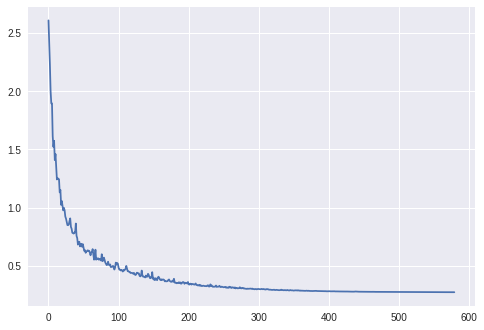

In [7]:
import matplotlib.pyplot as plt
plt.plot(costs)
plt.show()

#Look for the correct number of nodes and then try three layers.

**Try to compare the performance at the auto stop points and also the performances at certain iteration times. The intial guesses are generated using the same seeds.**

In [8]:
#Write a for loop that creates singler layer neural networks with different nodes.
nodes = np.arange(100, 1200, 50)
print(nodes)
#create neural network list and result list
NN_list = [i for i in nodes]
Result_list = []
for i in nodes:
    nn = neuralNetwork()
    nn.initialize(XTrain, np.array([i, 10]), Lambda=0.0)
    costs, results = NN.fit(yTrain_oneHot, learningRate=0.01, epochs=100, numBatches=20, realtime_eval=True, delta= 0.0001, XTest=XTest, yTest_oneHot=yTest_oneHot)
    
    NN_list.append({"nodes": i, "network": nn})
    Result_list.append({"nodes": i, "costs": costs, "results": results})
    nn.export()

[ 100  150  200  250  300  350  400  450  500  550  600  650  700  750
  800  850  900  950 1000 1050 1100 1150]
No sample data passed, please use load() or initialize() to build your network
No weights layers passed, please use load() or initialize() to build your network
All memory of current progress has been cleared
Randomly generating new network layers using hidden_nodes
The numbers of hidden nodes are:  [100  10]
The #0 weights layer is RNGed, shape:  <class 'list'> (100, 785)
The # 1  weights layer is RNGed, shape:  (10, 101)
The original sample:
 <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 0 ] is  <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 1 ] is  <class 'numpy.ndarray'> (7000, 100)
The generated neural layers: z[ 2 ] is  <class 'numpy.ndarray'> (7000, 10)
The a list: a[ 0 ] is <class 'numpy.ndarray'>
The a list: a[ 1 ] is <class 'numpy.ndarray'>
The output probabilities are:
 <class 'numpy.ndarray'> (7000, 10)
epoch 0
The cost 

The costs at the last point of fitting are:
100 0.18955605178755638
150 0.1512905640618812
200 0.13414595935768406
250 0.11896248892231492
300 0.11078005065548885
350 0.10103430794323673
400 0.09623171282948245
450 0.0890100017506292
500 0.08282664623663842
550 0.07805307920387422
600 0.07661055314007117
650 0.07321167260683617
700 0.06967952959288551
750 0.06900367427802591
800 0.06777667032526728
850 0.06602896182644498
900 0.06491226458424174
950 0.06428549743402615
1000 0.06190406821451882
1050 0.061724242738681545
1100 0.060975055336653546
1150 0.05931197592473591
The costs at the 250th iteration:
0.21056662904430642
0.16287431628853258
0.14063895275266186
0.12413350585658388
0.11418758396610225
0.10396134260383014
0.09790121065853621
0.0917477200010214
0.08539284366280572
0.07982801107397251
0.07889972320573796
0.07361434197672057
0.07102703188010281
0.07072373023074402
0.06919134145642535
0.06773463958888504
0.06519089801943974
0.0661927839514581
0.06272072517316257
0.0630540345

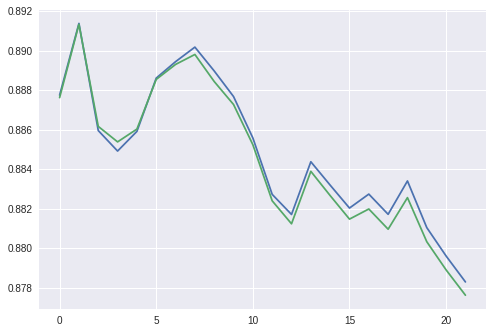

In [12]:
#result = {"confusion":confusion,"accMacro":accMacro, "precMacro":precMacro}
#For each iteration, a result list is returned. results = [result]
#This time, we return a list of the result list.

costs_end = []
acc_end = []
prec_end = []
costs_250 = []
acc_10 = []
prec_10 = []




print("The costs at the last point of fitting are:")
for i in Result_list:
    print(i['nodes'], i['costs'][len(i['costs']) - 1])
    costs_end.append(i['costs'][len(i['costs']) - 1])
    costs_250.append(i['costs'][250])
    
print("The costs at the 250th iteration:")
for i in costs_250:
    print(i)

**The costs keep dropping as we increase the number of nodes.
Let's see how precision and accuracy behaves.**

The precisions at the last point of fitting:
100 0.8877521282655583
150 0.8913805619886535
200 0.8859592298745917
250 0.884922171942598
300 0.8859174250031272
350 0.8886137152263464
400 0.88944441690006
450 0.8901810559783009
500 0.8889742753841707
550 0.887679364369286
600 0.8855838807625789
650 0.8827295983755006
700 0.8817136827816459
750 0.8843803525850644
800 0.8831971025268943
850 0.8820378349629843
900 0.8827437610738482
950 0.8817211311595881
1000 0.883408465673926
1050 0.8810479489905987
1100 0.879611482489462
1150 0.8782998848412635
The accuracy at the last point of fitting:
100 0.8876258638633596
150 0.8913337938408439
200 0.886169039319031
250 0.8853856803554259
300 0.886033657569644
350 0.8885478620134359
400 0.8893052655265865
450 0.8898087646914776
500 0.8884401521444593
550 0.8872774813295081
600 0.8852424109356235
650 0.8824041223539052
700 0.8812416556924362
750 0.8838953675199013
800 0.8826688265577133
850 0.8814781506625637
900 0.8819904669794771
950 0.8809674938952

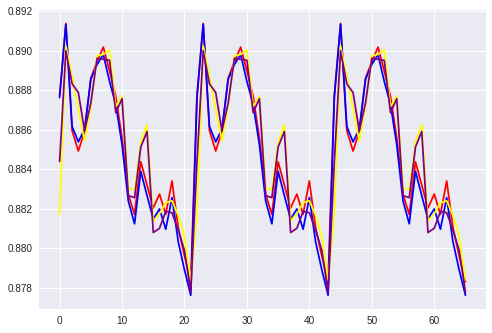

In [14]:
print("The precisions at the last point of fitting:")
for i in Result_list:
    print(i['nodes'], i['results'][len(i['results']) - 1]['accMacro'])
    acc_end.append(i['results'][len(i['results']) - 1]['accMacro'])
    acc_10.append(i['results'][10]['accMacro'])

print("The accuracy at the last point of fitting:")
for i in Result_list:
    print(i['nodes'], i['results'][len(i['results']) - 1]['precMacro'])
    prec_end.append(i['results'][len(i['results']) - 1]['precMacro'])
    prec_10.append(i['results'][10]['precMacro'])
    

fig, ax = plt.subplots()

ax.plot(acc_end, 'red')
ax.plot(prec_end, 'blue')
ax.plot(acc_10, 'yellow')
ax.plot(prec_10, 'purple')

plt.show()

Something is wrong with the length of the performance list. It repeated itself twice. And since we studied 100~1150 in steps of 50, clearly only the first 24 points are useful.
##The number of layers is chosen to be 450.
And we clearly didn't see an

#Change the number of layers to 3.

In [15]:
threeLayers = neuralNetwork()
threeLayers.initialize(XTrain, np.array([450, 450, 10]), Lambda=0.0)
costs, results = NN.fit(yTrain_oneHot, learningRate=0.01, epochs=100, numBatches=20, realtime_eval=True, delta= 0.0001, XTest=XTest, yTest_oneHot=yTest_oneHot)

nn.export()

No sample data passed, please use load() or initialize() to build your network
No weights layers passed, please use load() or initialize() to build your network
All memory of current progress has been cleared
Randomly generating new network layers using hidden_nodes
The numbers of hidden nodes are:  [450 450  10]
The #0 weights layer is RNGed, shape:  <class 'list'> (450, 785)
The # 1  weights layer is RNGed, shape:  (450, 451)
The # 2  weights layer is RNGed, shape:  (10, 451)
The original sample:
 <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 0 ] is  <class 'numpy.ndarray'> (7000, 784)
The generated neural layers: z[ 1 ] is  <class 'numpy.ndarray'> (7000, 450)
The generated neural layers: z[ 2 ] is  <class 'numpy.ndarray'> (7000, 450)
The generated neural layers: z[ 3 ] is  <class 'numpy.ndarray'> (7000, 10)
The a list: a[ 0 ] is <class 'numpy.ndarray'>
The a list: a[ 1 ] is <class 'numpy.ndarray'>
The a list: a[ 2 ] is <class 'numpy.ndarray'>
The output probabi

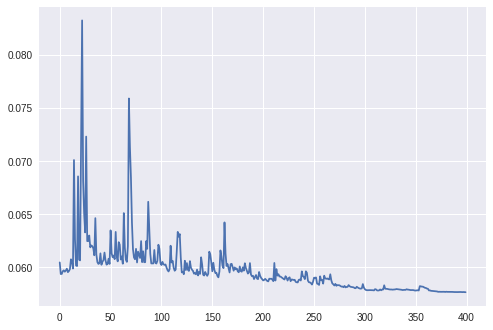

In [16]:
plt.plot(costs)
plt.show()